99.09731113956465


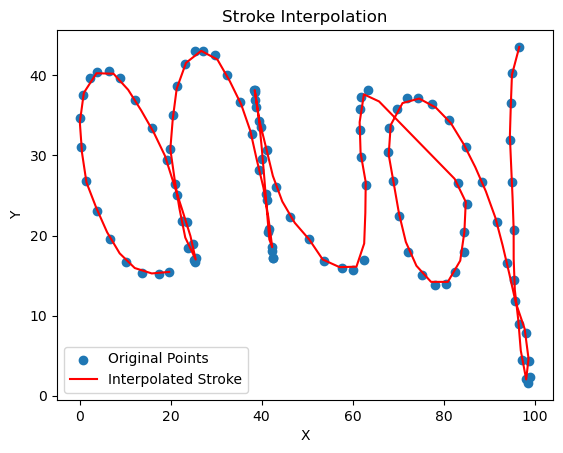

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def interpolate_stroke(x, y, num_points):
    """
    Interpolate points along a stroke.

    Parameters:
    - x: array-like, x-coordinates of the original points.
    - y: array-like, y-coordinates of the original points.
    - num_points: int, the number of equidistant points to interpolate.

    Returns:
    - interpolated_points: array-like, m x-coordinates and y-coordinates of the interpolated points.
    """
    # Calculate the cumulative distance along the stroke
    cumulative_distance = np.cumsum(np.sqrt(np.diff(x)**2 + np.diff(y)**2))
    cumulative_distance = np.insert(cumulative_distance, 0, 0)  # Insert 0 at the beginning

    # Normalize the cumulative distance to range [0, 1]
    normalized_distance = cumulative_distance / cumulative_distance[-1]

    # Interpolate equidistant points
    interpolated_normalized_distance = np.linspace(0, 1, num_points)
    interpolated_x = np.interp(interpolated_normalized_distance, normalized_distance, x)
    interpolated_y = np.interp(interpolated_normalized_distance, normalized_distance, y)

    # Combine x and y values into a 2D array
    interpolated_points = np.column_stack((interpolated_x, interpolated_y))

    return interpolated_points

# Example usage:
# Replace x_data and y_data with your actual data
file_path = 'stroke_43757.npy'
points = np.load(file_path)
x_data = points[:, 0]
y_data = points[:, 1]

# Set the number of equidistant points for interpolation
img_width = max(x_data)
num_equidistant_points = int(img_width)
print(img_width)

# Get the interpolated points
interpolated_points = interpolate_stroke(x_data, y_data, num_equidistant_points)

# Plot the original points and the interpolated stroke
plt.scatter(x_data, y_data, label='Original Points')
plt.plot(interpolated_points[:, 0], interpolated_points[:, 1], label='Interpolated Stroke', color='red')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Stroke Interpolation')
plt.show()